In [5]:
import os
import sys

import numpy as np
import torch as th
from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Any

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

%load_ext autoreload
%autoreload 2

import motornet as mn

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

device = th.device("cpu")
th.set_default_device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All packages imported.
pytorch version: 2.0.1
numpy version: 1.25.2
motornet version: 0.2.0


In [6]:
## Define the task
class ExpTask:
    def __init__(self, effector, **kwargs):
        self.effector = effector
        self.dt = self.effector.dt
        self.pre_range = kwargs.get('pre_range', [0.3, 0.3])
        self.c1_range = kwargs.get('c1_range', [0.6, 1.0])
        self.c2_range = kwargs.get('c2_range', [0.6, 1.0])
        self.size_range = kwargs.get('size_range', [0., 0.02])  # 4cm diameter max
        self.target_size = kwargs.get('target_size', 0.0)
        self.background_load = kwargs.get('background_load', 0.)
        self.run_mode = kwargs.get('run_mode', 'train')
        self.delay_range = [5000, 5000]  # this has to exist to get the size of the inputs

    def generate(self, batch_size, n_timesteps, **kwargs):
        goal_states = self.effector.joint2cartesian(self.effector.draw_random_uniform_states(batch_size=batch_size)).to("cpu").numpy()
        targets = np.tile(np.expand_dims(goal_states, axis=1), (1, n_timesteps, 1))
        prob_array = np.array([0, 0.25, 0.5, 0.75, 1])
        inputs = np.zeros(shape=(batch_size, n_timesteps, 5 + 2 + 2 + 1 + 1))
        perturbations = np.zeros(shape=(batch_size, n_timesteps, 2))
        if self.run_mode == 'experiment':
            catch_chance = 0.
            prob_chance = 1.
            self.pre_range = [0., 0.]
            self.c1_range = [0.1, 0.1]
            self.c2_range = [0.6, 0.6]
            self.target_size = [0.006]  #0.02
        elif self.run_mode == 'train_experiment':
            self.target_size = [0.006]
            prob_chance = 0.5
            catch_chance = 0.5
        else:
            catch_chance = 0.5  # 0.7 best
            prob_chance = 0.5  # 0.8 best

        base_joint = np.deg2rad([32., 72., 0., 0.])
        center_base = self.effector.joint2cartesian(th.tensor(base_joint)).to("cpu").numpy()
        base_joint_rand = np.zeros((batch_size,4))
        for i in range(batch_size):
            A = np.expand_dims(base_joint, axis=0)
            B = np.concatenate((np.random.uniform(low=-0.3, high=0.3, size=(1, 2)), np.zeros((1,2))), axis=1)
            base_joint_rand[i,:] = A + B
        if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
            init_states = np.repeat(np.expand_dims(base_joint, axis=0), batch_size, axis=0)
        else:
            init_states = base_joint_rand

        if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
            background_loads = np.repeat(np.expand_dims(np.array([0, self.background_load]), axis=0),
                                         batch_size, axis=0)
        else:
            background_loads = np.concatenate((np.random.uniform(low=-0.2, high=0.2, size=(batch_size, 1)),
                                               np.random.uniform(low=self.background_load-0.2,
                                                                 high=self.background_load+0.2,
                                                                 size=(batch_size, 1))), axis=1)
        for i in range(batch_size):
            center_joint = init_states[i, :]
            center = self.effector.joint2cartesian(th.tensor(center_joint)).to("cpu").numpy()
            goal_state1 = center  # monkey version
            goal_state2 = center  # monkey version
            c1_time = generate_delay_time(self.pre_range[0] / self.dt, self.pre_range[1] / self.dt, 'random')
            c2_time = c1_time + generate_delay_time(self.c1_range[0] / self.dt, self.c1_range[1] / self.dt, 'random')
            pert_time = c2_time + generate_delay_time(self.c2_range[0] / self.dt, self.c2_range[1] / self.dt, 'random')
            target_size = np.random.uniform(self.size_range[0], self.size_range[1])
            # cue order not randomized
            targ_time = c1_time
            prob_time = c2_time
            # is this a catch trial?
            if np.greater_equal(np.random.rand(), catch_chance):
                is_catch = False
            else:
                is_catch = True
                pert_time = 10000
            # is this a probability trial?
            if np.greater_equal(np.random.rand(), prob_chance):
                is_prob = False
            else:
                is_prob = True
            # Inputs
            # pick one of our 5 visual cues
            rand_cue = np.random.randint(0, 5)
            if is_prob:
                if True:#self.run_mode == 'experiment':
                    turn_off_time = pert_time - prob_time + 8
                else:
                    turn_off_time = int(np.random.rand() * (inputs.shape[1] - prob_time))
                inputs[i, prob_time: (prob_time + turn_off_time), rand_cue] = 1
                elb_prob = prob_array[rand_cue]
            else:
                elb_prob = 0.5
            if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
                target_size = self.target_size
                # Targets
                if np.random.rand() < 0.5:
                    targets[i, :, :] = np.tile(np.expand_dims(goal_state1, axis=1), [1, n_timesteps, 1])
                else:
                    targets[i, :, :] = np.tile(np.expand_dims(goal_state2, axis=1), [1, n_timesteps, 1])
            elif self.run_mode == 'train':
                # Targets
                r = 0.08 * np.sqrt(np.random.rand())
                theta = np.random.rand() * 2 * np.pi
                new_pos = center_base[0, 0:2] + np.expand_dims([r * np.cos(theta), r * np.sin(theta)], axis=0)
                targets[i, :, 0:2] = np.tile(np.expand_dims(new_pos, axis=1), [1, n_timesteps, 1])

            # where we're going
            if True:#self.run_mode == 'experiment':
                turn_off_time = inputs.shape[1]
            else:
                turn_off_time = int(np.random.rand() * (inputs.shape[1] - targ_time))
            inputs[i, targ_time: (targ_time + turn_off_time), -4:-2] = targets[i, targ_time, 0:2]
            # where we come from
            inputs[i, :, -6:-4] = center[:, 0:2]
            # then we turn that off
            #inputs[i, (pert_time + 8):, -6:-4] = targets[i, -1, 0:2]

            perturbation = np.repeat(np.expand_dims(background_loads[i, :], axis=0), n_timesteps, axis=0)  # background load
            if not is_catch:
                targets[i, 0:pert_time, :] = center
                if is_prob:
                    if np.random.rand() < elb_prob:
                        perturbation[pert_time:, :] = background_loads[i, :] - [0, 1]
                    else:
                        perturbation[pert_time:, :] = background_loads[i, :] + [0, 1]
                else:
                    perturbation[pert_time:, :] = background_loads[i, :] + np.random.uniform(-2., 2., size=(1, 2))
                # Adding back condition independent pulse
                inputs[i, (pert_time + 3):, -1] = 1.  # 1 (+3)
            else:
                targets[i, :, :] = center

            # let's tell the network how big the target is
            inputs[i, targ_time:, -2] = target_size

            inputs[i, :, :] = inputs[i, :, :] + np.random.normal(loc=0., scale=1e-3,
                                                                 size=(inputs.shape[1], inputs.shape[2]))
            perturbations[i, :, :] = perturbation

        all_inputs = {"inputs": inputs, "joint_load": perturbations}
        return [all_inputs, targets, init_states]

def generate_delay_time(delay_min, delay_max, delay_mode):
    if delay_mode == 'random':
        delay_time = np.random.uniform(delay_min, delay_max)
    elif delay_mode == 'noDelayInput':
        delay_time = 0
    else:
        raise AttributeError

    return int(delay_time)



In [7]:
## Define the gym environment for the task
class ExpTaskEnv(mn.environment.Environment):
  def __init__(self, *args, **kwargs):
    # pass everything as-is to the parent Environment class
    super().__init__(*args, **kwargs)
    self.__name__ = "ExpTask"

  def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None):
    self._set_generator(seed)  # seed the environment and the effector

    options = {} if options is None else options
    batch_size: int = options.get("batch_size", 1)
    joint_state: th.Tensor | np.ndarray | None = options.get("joint_state", None)
    deterministic: bool = options.get("deterministic", False)

    self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
  
    goal = self.joint2cartesian(self.effector.draw_random_uniform_states(batch_size)).chunk(2, dim=-1)[0]
    self.goal = goal if self.differentiable else self.detach(goal)
    self.elapsed = 0.
    action = th.zeros((batch_size, self.muscle.n_muscles)).to(self.device)
  
    self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
    self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
    self.obs_buffer["action"] = [action] * self.action_frame_stacking

    obs = self.get_obs(deterministic=deterministic)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": action,  # no noise here so it is the same
      "goal": self.goal,
      }
    return obs, info

  def step(self, action, deterministic: bool = False, **kwargs):
    self.elapsed += self.dt

    if deterministic is False:
      noisy_action = self.apply_noise(action, noise=self.action_noise)
    else:
      noisy_action = action
    
    self.effector.step(noisy_action, **kwargs)
    self.goal = self.goal.clone()

    obs = self.get_obs(action=noisy_action)
    reward = None
    truncated = False
    terminated = bool(self.elapsed >= self.max_ep_duration)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": noisy_action,
      "goal": self.goal,
      }
    return obs, reward, terminated, truncated, info

  def get_proprioception(self):
    mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
    mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
    prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
    return self.apply_noise(prop, self.proprioception_noise)

  def get_vision(self):
    vis = self.states["fingertip"]
    return self.apply_noise(vis, self.vision_noise)

  def get_obs(self, action=None, deterministic: bool = False):
    self.update_obs_buffer(action=action)

    obs_as_list = [
      self.goal,
      self.obs_buffer["vision"][0],  # oldest element
      self.obs_buffer["proprioception"][0],   # oldest element
      ]
    obs = th.cat(obs_as_list, dim=-1)

    if deterministic is False:
       obs = self.apply_noise(obs, noise=self.obs_noise)
    return obs

dt = 0.01
ep_dur = 2
env = ExpTaskEnv(max_ep_duration=ep_dur, effector=mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle(), timestep=dt), proprioception_delay=0.02, vision_delay=0.07, proprioception_noise=1e-3, vision_noise=1e-3, action_noise=1e-4)

print("Task subclass built.\n")
obs, info = env.reset()
print("obs shape:          ", obs.shape, end="\n\n\n")
for key, val in info.items():
  if type(val) is dict:
    print(key + ": ")
    for k, v in val.items():
      print("\t\t\t" + k + " shape:" + " " * (10-len(k)), v.shape)
  else:
    print(key + " shape:" + " " * (13-len(key)), val.shape)

Task subclass built.

obs shape:           torch.Size([1, 16])


states: 
			joint shape:      torch.Size([1, 4])
			cartesian shape:  torch.Size([1, 4])
			muscle shape:     torch.Size([1, 7, 6])
			geometry shape:   torch.Size([1, 4, 6])
			fingertip shape:  torch.Size([1, 2])
action shape:        torch.Size([1, 6])
noisy action shape:  torch.Size([1, 6])
goal shape:          torch.Size([1, 2])


In [8]:
## Initialize
n_t = int(ep_dur / env.effector.dt)
params = {'pre_range': [0., 0.], 'c1_range': [0., 0.2], 'c2_range': [0., 1.75], 'background_load': 0., 'run_mode': 'train'}
task = ExpTask(effector=env.effector, **params)
inputs, targets, init_states = task.generate(1, n_t)

In [9]:
## Define the policy (RNN)
class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        self.init_h = th.nn.parameter.Parameter(th.empty((self.n_layers, 1, self.hidden_dim)))
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            elif name == "init_h":
                th.nn.init.xavier_uniform_(param)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        hidden = th.tile(self.init_h, (1, batch_size, 1))
        return hidden
    
    
env.to(device)
## Initialize
policy = Policy(env.observation_space.shape[0] + inputs['inputs'].shape[2], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=1e-3)

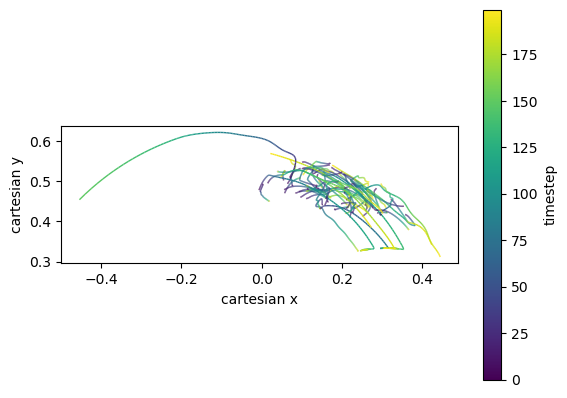

Cartesian:0.0722 Muscle:0.0018 Velocity:0.0090 Input:0.00930 Recurrent:0.00926
Batch 270/1000 Done, mean policy loss: 0.0882


KeyboardInterrupt: 

In [10]:
%%time
batch_size = 64
n_batch = 1000
losses = []
interval = 10

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

## Train
for batch in range(n_batch):
  inputs, targets, init_states = task.generate(batch_size, n_t)
  targets = th.tensor(targets[:,:,0:2], device=device, dtype=th.float)
  inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
  loads = th.tensor(inputs['joint_load'], device=device, dtype=th.float)
  init_states = th.tensor(init_states, device=device, dtype=th.float)
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)
  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  terminated = False

  # initial positions and targets
  xy = []
  all_actions = []
  all_muscle = []
  all_hidden = []

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(env.elapsed / env.dt)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action, **{'joint_load': loads[:,t_step,:]})

    xy.append(info['states']['cartesian'][:, None, :])  # trajectories
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_hidden.append(h[0,:,None,:])
  
  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  all_hidden = th.cat(all_hidden, axis=1)
  all_actions = th.cat(all_actions, axis=1)
  all_muscle = th.cat(all_muscle, axis=1)
  
  # calculate losses
  cartesian_loss = l1(xy[:,:,0:2], targets)
  muscle_loss = 0.1 * th.mean(th.sum(th.square(all_muscle), dim=-1))
  velocity_loss = 0.1 * th.mean(th.sum(th.abs(xy[:,:,2:]), dim=-1))
  input_loss = 1e-4 * th.sum(th.square(policy.gru.weight_ih_l0))
  recurrent_loss = 1e-4 * th.sum(th.square(policy.gru.weight_hh_l0))
  loss = cartesian_loss + muscle_loss + velocity_loss
  
  # backward pass & update weights
  optimizer.zero_grad()
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())
  
  if (batch % interval == 0) and (batch != 0):
      clear_output(wait=True)
      f1, ax1 = plt.subplots()
      mn.plotor.plot_pos_over_time(xy[:,:,0:2].cpu().detach(), ax1)
      plt.show()
      print("Cartesian:{:.4f} Muscle:{:.4f} Velocity:{:.4f} Input:{:.5f} Recurrent:{:.5f}".format(cartesian_loss.detach().cpu(), muscle_loss.detach().cpu(), velocity_loss.detach().cpu(), input_loss.detach().cpu(), recurrent_loss.detach().cpu()))
      print("Batch {}/{} Done, mean policy loss: {:.4f}".format(batch, n_batch, sum(losses[-interval:])/interval))

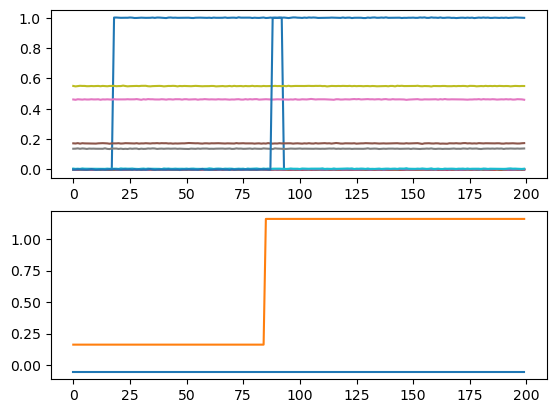

In [17]:
inputs['inputs'].shape
ii = 3
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(inputs['inputs'][ii,:,:])
ax[1].plot(inputs['joint_load'][ii,:,:])

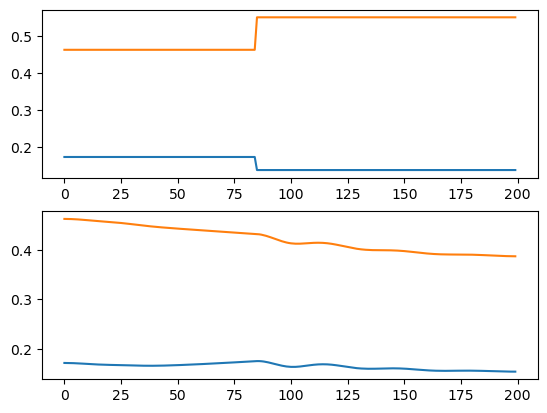

In [12]:
ii = 3
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(targets.detach().cpu().numpy()[ii,:,:])
ax[1].plot(xy.detach().cpu().numpy()[ii,:,0:2])

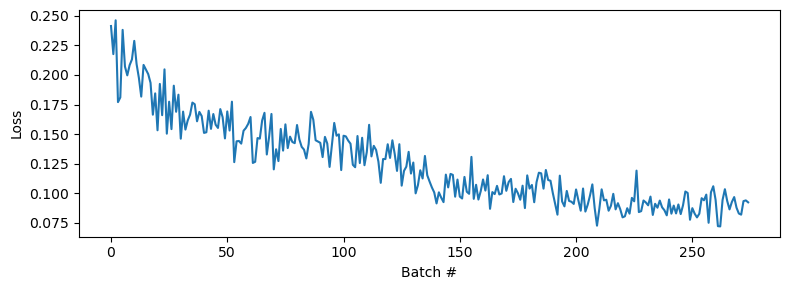

In [13]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  #axs.semilogy(log)
  axs.plot(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

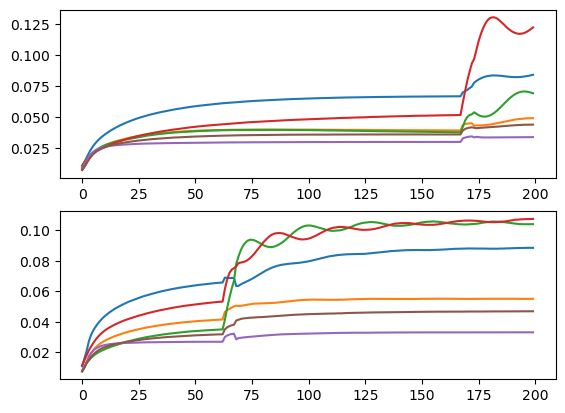

In [14]:
ii = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(all_actions.detach().cpu().numpy()[ii,:,:])
ax[1].plot(all_actions.detach().cpu().numpy()[ii+1,:,:])

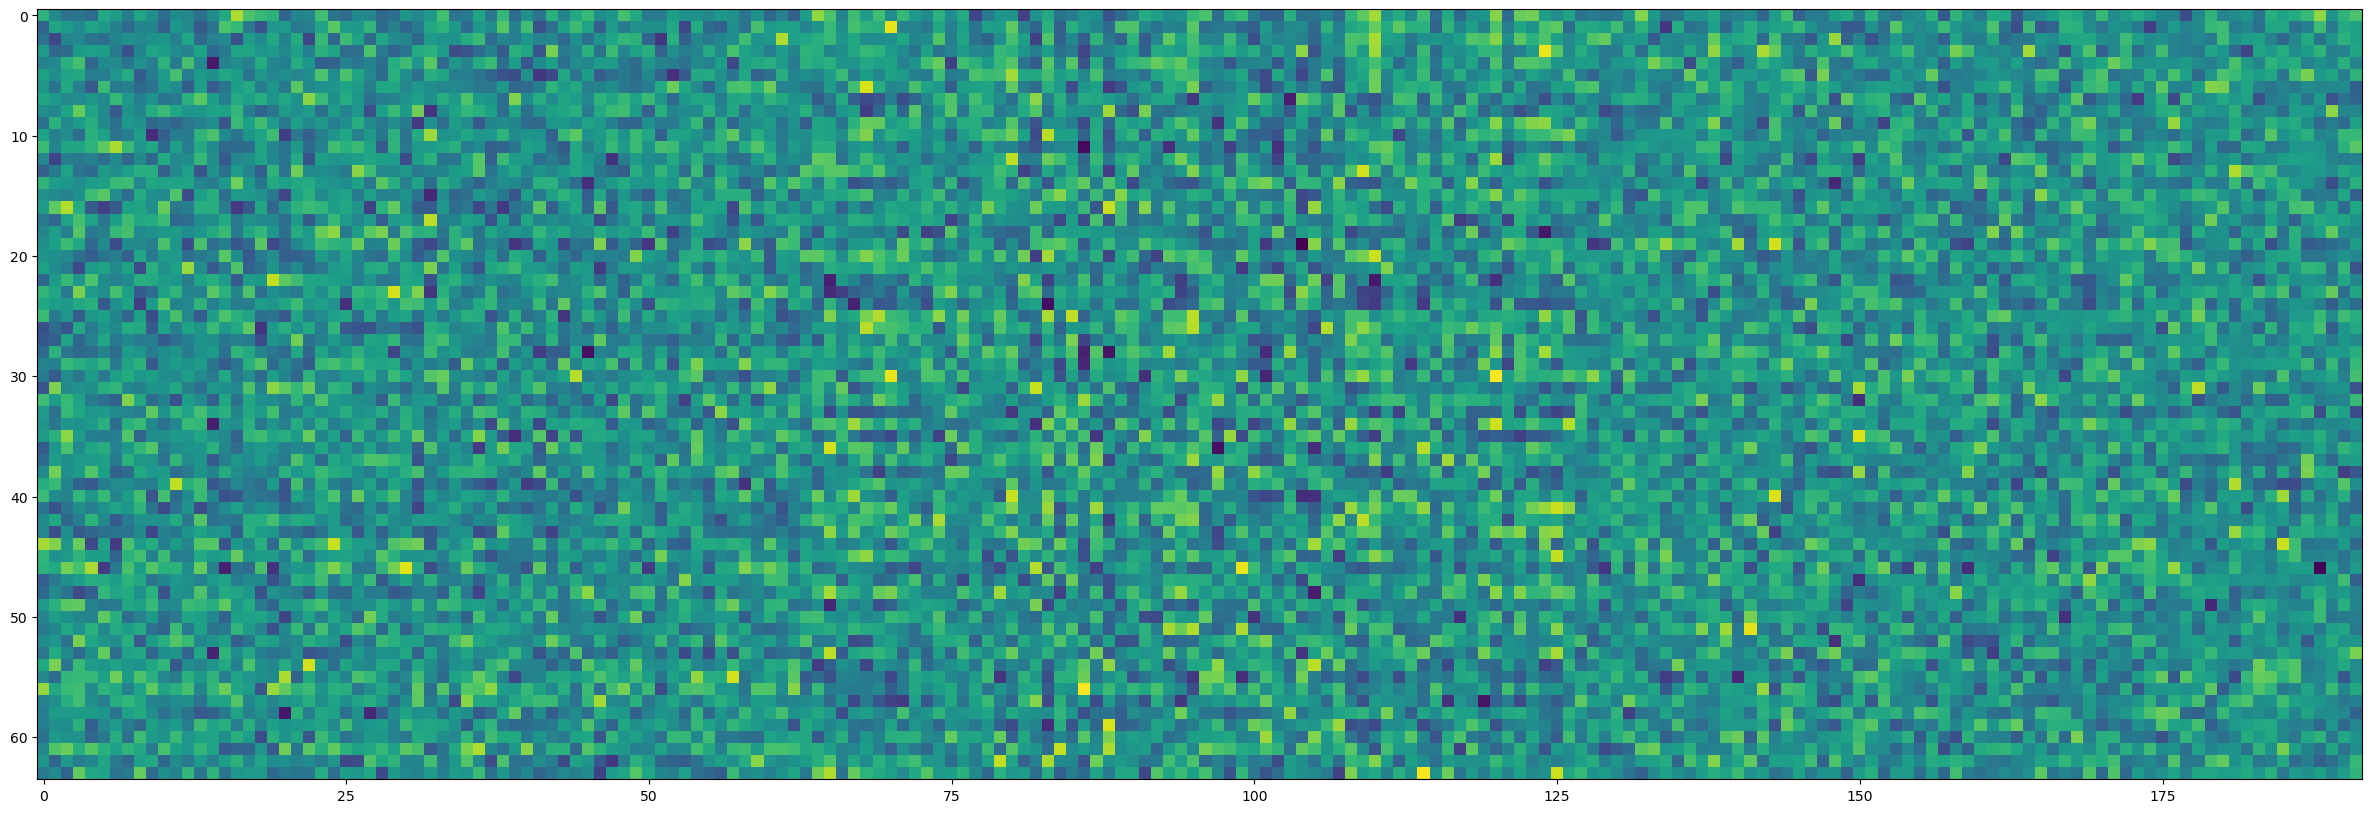

In [15]:
plt.figure(figsize=(30,10))
plt.imshow(policy.gru.weight_hh_l0.detach().cpu().numpy().transpose(), aspect='auto', interpolation='none')
plt.show()

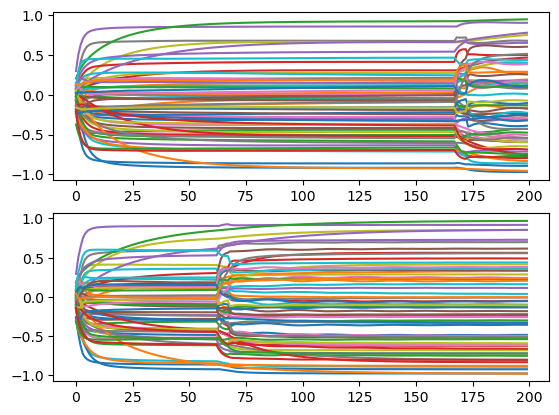

In [16]:
ii = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(all_hidden.detach().cpu().numpy()[ii,:,:])
ax[1].plot(all_hidden.detach().cpu().numpy()[ii+1,:,:])